In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [2]:
#train and test data directory
data_dir = "/lwork/ZhiyangXia/data/ml/data/"
#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((128,128)),transforms.ToTensor()
]))
print(dataset)

Dataset ImageFolder
    Number of datapoints: 108802
    Root location: /lwork/ZhiyangXia/data/ml/data/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [3]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
def get_class_distribution(dataset):
    count_dict = {k:0 for k,v in dataset.class_to_idx.items()} # initialise dictionary
    count = 0
    for input, label in dataset:
        label = idx_to_class[label]
        count_dict[label] += 1
        count +=1
        print(count, end='\r')    
    return count_dict

print("Distribution of classes: ", get_class_distribution(dataset))

Distribution of classes:  {'chorus': 31215, 'lgw': 30754, 'other': 46833}


In [5]:

print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['chorus', 'lgw', 'other']


Label : chorus


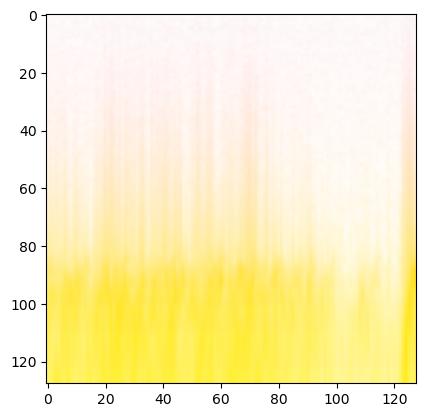

In [6]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

In [7]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = 10000
test_size = 20000
train_size = len(dataset) - val_size - test_size

train_data,val_data, test_data = random_split(dataset,[train_size,val_size,test_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
print(f"Length of Test Data : {len(test_data)}")
#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 78802
Length of Validation Data : 10000
Length of Test Data : 20000


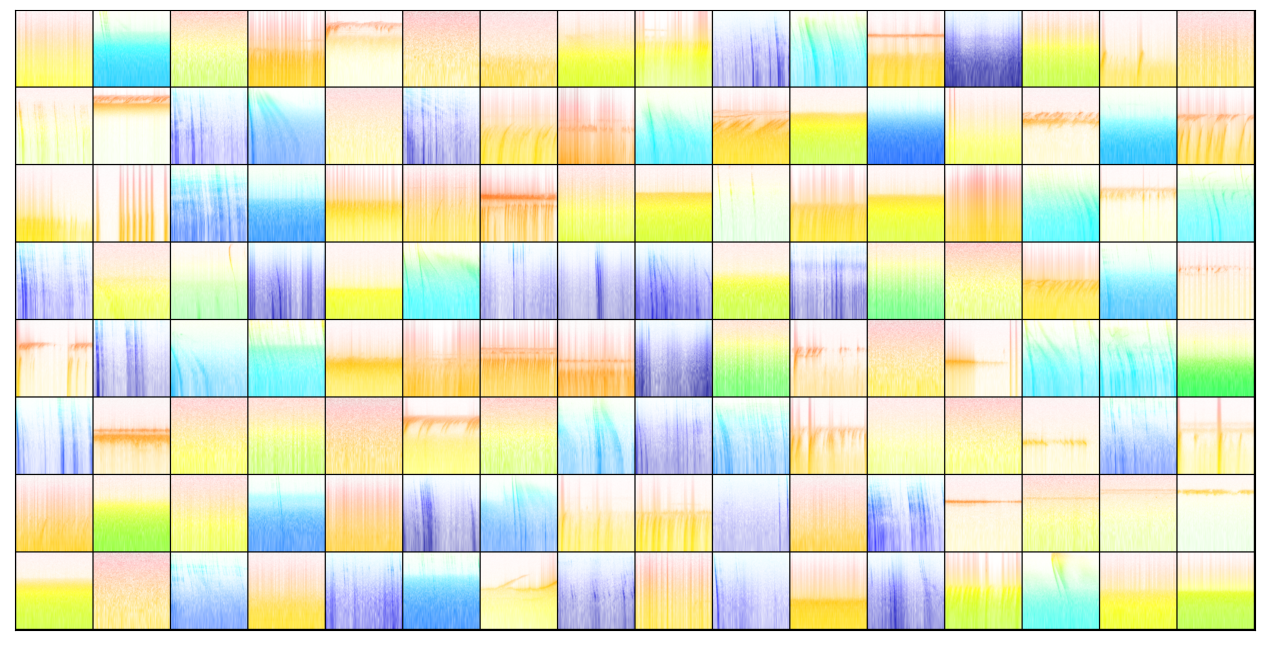

In [8]:

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [10]:

class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(65536,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [11]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [12]:
model = NaturalSceneClassification()
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.5205, val_loss: 0.3251, val_acc: 0.8813
Epoch [1], train_loss: 0.3202, val_loss: 0.2922, val_acc: 0.8921
Epoch [2], train_loss: 0.2673, val_loss: 0.3341, val_acc: 0.8574
Epoch [3], train_loss: 0.2387, val_loss: 0.2412, val_acc: 0.9077
Epoch [4], train_loss: 0.2226, val_loss: 0.2587, val_acc: 0.9057
Epoch [5], train_loss: 0.2110, val_loss: 0.2370, val_acc: 0.9142
Epoch [6], train_loss: 0.1948, val_loss: 0.2435, val_acc: 0.9146
Epoch [7], train_loss: 0.1763, val_loss: 0.2604, val_acc: 0.9099
Epoch [8], train_loss: 0.1532, val_loss: 0.3371, val_acc: 0.8955
Epoch [9], train_loss: 0.1293, val_loss: 0.3019, val_acc: 0.9090
Epoch [10], train_loss: 0.1072, val_loss: 0.3540, val_acc: 0.9015
Epoch [11], train_loss: 0.0886, val_loss: 0.4408, val_acc: 0.9004
Epoch [12], train_loss: 0.0693, val_loss: 0.4847, val_acc: 0.8983
Epoch [13], train_loss: 0.0586, val_loss: 0.5352, val_acc: 0.9018
Epoch [14], train_loss: 0.0515, val_loss: 0.5585, val_acc: 0.9040
Epoch [15], train_lo

In [13]:

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    



def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');



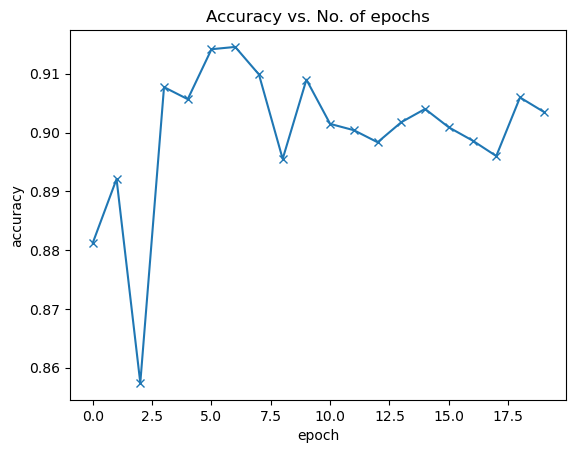

In [14]:
plot_accuracies(history)

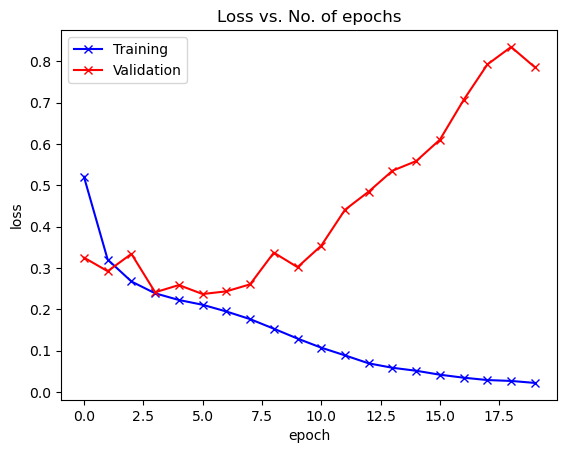

In [15]:
plot_losses(history)

In [16]:
test_result = evaluate(model, test_dl)

In [17]:
print(test_result)

{'val_loss': 0.7467136383056641, 'val_acc': 0.9028382301330566}


In [18]:
model = torch.load('model1.pt')

FileNotFoundError: [Errno 2] No such file or directory: 'model1.pt'

In [19]:
from sklearn.metrics import confusion_matrix
#
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dl:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth



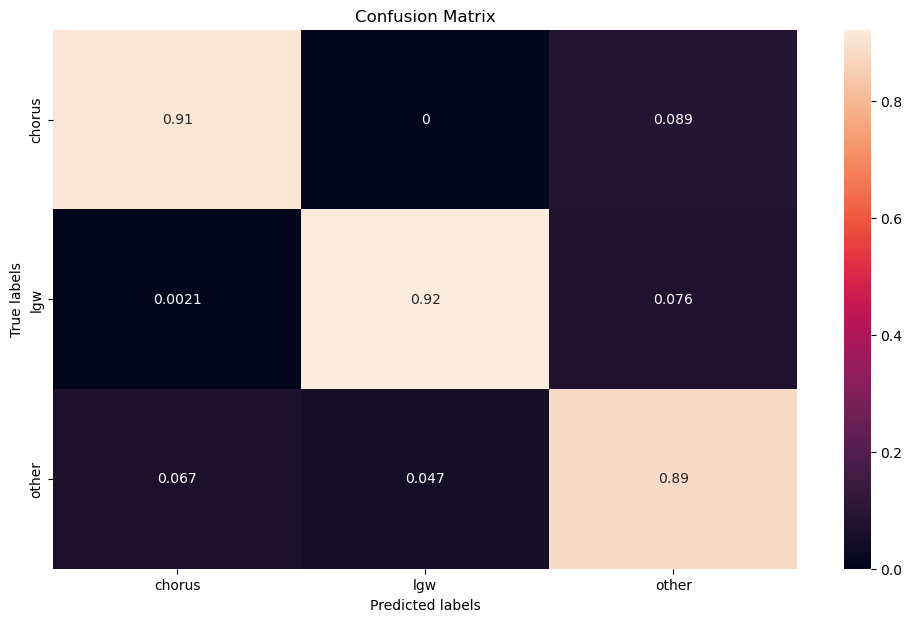

In [20]:
import numpy as np
import seaborn as sn
# constant for classes
classes = dataset.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted labels');
plt.ylabel('True labels'); 
plt.title('Confusion Matrix'); 

In [21]:
#torch.save(model, 'model1.pt')

In [22]:
print(cf_matrix)

[[5232    0  514]
 [  12 5191  427]
 [ 577  407 7640]]


In [23]:
print(len(y_pred))

20000
